In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# plot signal spectrum
def plot_spec(sig):
    mysig = atleast_2d(sig)
    figure(figsize=(6,6))
    faxis=fftfreq(mysig.shape[1],1/2)
    psd = 20*log10(abs(fft.fft(mysig[0])))
    plot(faxis,psd-psd.max())
    xlabel("Normalized Frequency")
    ylabel("Relative Power")
    title("Signal spectrum")

# plot 1-D signal
def plot_1d(mysig):
    figure(figsize=(6,6))
    plot(mysig.real.flatten(),mysig.imag.flatten(),'b.')
    axis("square")
    # xticks([])
    # yticks([])
    # axis([-1.5,1.5,-1.5,1.5])
    title("Complete Frame")
    show()

In [3]:
from qampy.core import io
from qampy import signals,impairments,helpers,equalisation,io,filtering,phaserec, helpers
from qampy.core import impairments as impair

# Data generation

Import ML-based payload

In [4]:
fnsig = 'C:/Users/Zonglong/PycharmProjects/Jinxiang/geometric_shaping_signals.gz'
sig_payload_obj = io.load_signal(fnsig)

Generate pilot object with ML-based payload

In [5]:
M = 64                  # modulation format
pilot_seq_len = 1024    # pilot squence length, notice:phase pilots are not included 
pilot_ins_rat = 32      # i.e. for every 32 symbol, one phase pilot symbol is inserted 
N = 2**16               # total sequence length (Sequenc pilot + phase pilot + payload)
nmodes = 2              # number of polarization mode
fb = 40e9               # symbol rate
N_pl = int( (N-pilot_seq_len)*(pilot_ins_rat-1)/pilot_ins_rat )  # payload sequence length

pilot_sig = signals.SignalWithPilots(M, N, pilot_seq_len, pilot_ins_rat, nmodes=nmodes, Mpilots=4, nframes=2, fb=fb)
pilot_sig_pl = pilot_sig.from_symbol_array(sig_payload_obj, N, pilot_seq_len, pilot_ins_rat, pilots=None, nframes=2)

Matching filter (RRC filter) and oversampling

In [6]:
roll_off = 0.1   # roll-off factor of rrc filter
os_rate = 2      # over-sampling rate
pilot_sigResam = pilot_sig_pl.resample(os_rate*pilot_sig.fb, beta=roll_off, renormalise=True)

delay = 10000    # delay 10000 symbol on purpose of synchronization
sig_delay = np.roll(pilot_sigResam,delay,axis=-1)

Get pilot index

In [7]:
idx_pil = helpers.find_pilot_idx(frame_len = 2 ** 16)
idx_pil_shift = np.roll(idx_pil, delay, axis=-1)

# Tx model

In [8]:
des_swing = 0.8 * 3.5
sig_mod_out = impairments.sim_tx_response(sig_delay, enob=5, cutoff=16e9, tgt_V=des_swing, p_in=0, dac_filter=False, clipping=False)

# Channel model

In [9]:
snr = 28
noise_var = 10**(-13.6/10)/10**(snr/10) * (pilot_sigResam.fs/pilot_sigResam.fb)
sig_h = impairments.add_awgn(sig_mod_out, np.sqrt(noise_var))

# Rx

## Pilot-DSP

In [10]:
rxsig = sig_h.resample(2*pilot_sig.fb, beta=roll_off)
rxsig = helpers.normalise_and_center_pil(rxsig, idx_pil_shift)

rxsig.sync2frame()
eq_sig = equalisation.pilot_equalizer(rxsig, (1e-2,1e-2), 31, foe_comp=False, methods=("mcma","mddma"))
cpe_sig = phaserec.pilot_cpe(eq_sig[1],N=5,use_seq=False)
rxsig2 = cpe_sig[0].extract_pilots()

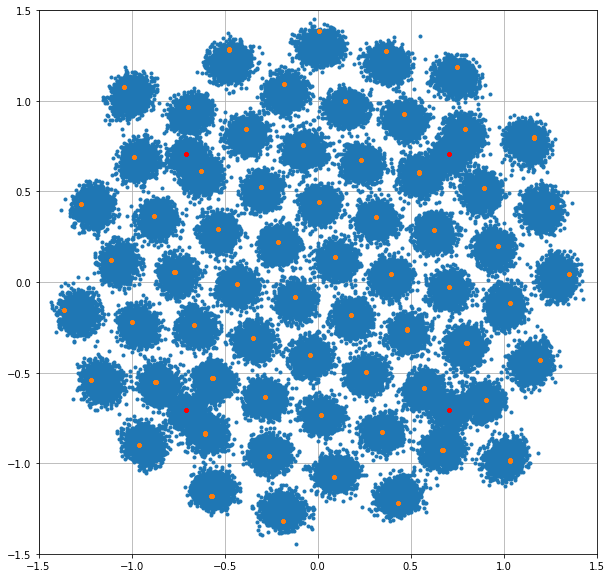

In [11]:
figure(figsize=(10,10))
plot(cpe_sig[0].real.flatten(), cpe_sig[0].imag.flatten(),'.')
plot(sig_payload_obj.real.flatten(), sig_payload_obj.imag.flatten(),'.')
plot(cpe_sig[0].pilots.real.flatten(), cpe_sig[0].pilots.imag.flatten(),'r.')
xlim(-1.5, 1.5)
ylim(-1.5, 1.5)
grid()
show()